<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es8/AML_2023_HandsOn_8_IG_tracIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xAI handOn based on the first one!

Slide for the day with the Task Description ([SLIDE](https://docs.google.com/presentation/d/1DCZn-I8bXQ_awkmR6I6u9be4MCHB0ljWTxBL9koOsXo/edit?usp=sharing))

Jamboard for first RiNNGs ([BOARD](https://jamboard.google.com/d/1n694UZc-sQK2AZnI4RX88d-hoPytOPo_-5wnt3Bwlbc/edit?usp=sharing))

Jamborad for today ([BOARD](https://jamboard.google.com/d/1MAaDvaBTjy3RluS62r8mXKiOI6ZWDKc8Mn7BZap62eA/edit?usp=sharing))

[PAPER INTEGRATED GRADIENTS](https://arxiv.org/pdf/1703.01365.pdf)

[PAPER TRACIN](https://arxiv.org/pdf/2002.08484.pdf)

# Connect your drive!

In [ ]:
from google.colab import drive
import numpy as np

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!cd /content/gdrive/MyDrive/RiNNgs # this one may be different from mine

In [ ]:
!ls

data  data_preprocess.py  gdrive  results  sample_data


In [ ]:
# we need to get some files from github
import os
success = os.path.exists("./data_preprocess.py")
if not success:
 
  ! wget https://raw.githubusercontent.com/stefanogiagu/corso_AML_2023/main/notebooks/es1/data_preprocess.py

In [ ]:
!ls

data  data_preprocess.py  gdrive  results  sample_data


# Lets create all the folders needed

In [ ]:
import os
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("results")#
CreateDir("results/display")
CreateDir("results/preprocess")
CreateDir("data")

In [ ]:
success = os.path.exists("data/event_08011.file")
if not success:
  ! wget  https://raw.githubusercontent.com/stefanogiagu/corso_AML_2023/main/notebooks/es1/data/event_08011.file -P data/
  ! wget -P data/ https://raw.githubusercontent.com/stefanogiagu/corso_AML_2023/main/notebooks/es1/data/RICH_map_corr_2017.data
  ! wget -P data/ https://raw.githubusercontent.com/stefanogiagu/corso_AML_2023/main/notebooks/es1/data/data_08011.json

# We need to build the dataset.
How can we call a python code from a notebook script?

Use the command


```
! python script.py ARG1,ARG2,...,ARGN
```

to call the "data_preprocess.py" that will find the run 0811 and form 16x16 images from it.

arguments are "08011 Conv 16 np_reco 0"

**Ignore all the warnings and the tensorflow calls. This function is doing a lot more than what we need**

In [ ]:
dataset = "08011"
success = os.path.exists('results/preprocess/' + 'x_all_{}.npy'.format(dataset))
if not success:
  ! python data_preprocess.py 08011 Conv 16 np_reco 0


x_all =  np.load( 'results/preprocess/' + 'x_all_{}.npy'.format(dataset))
y_all = np.load('results/preprocess/' + 'y_all_{}.npy'.format(dataset))

# Where are our files?

The script will write two files in the results/preprocess folder that we created before.

Check if you can find the files and that  *x_all_** is the rigth size (around 40 MB)

Use the command


```
ls -lh "path"
```



In [ ]:
! ls -lh  results/preprocess/

total 40M
-rw-r--r-- 1 root root  82K May 15 18:47 prova16.pdf
-rw-r--r-- 1 root root  40M May 15 18:47 x_all_08011.npy
-rw-r--r-- 1 root root 313K May 15 18:47 y_all_08011.npy


# Read the data, check the data format, print an element.


*   Load the data with np.load
*   Print the data shape
*   Check the variable type
*   Use plt.matshow() to print an element



In [ ]:

# remove the empty images
def remove_empty(x_all, y_all):
  intensities = x_all.reshape(x_all.shape[0],-1).sum(axis=1)
  y_all = y_all[intensities>5]
  x_all = x_all[intensities>5]
  return x_all, y_all

x_all, y_all = remove_empty(x_all, y_all)


[0. 1.]


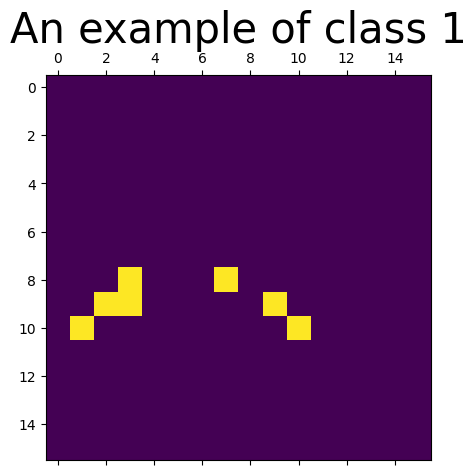

In [ ]:
import matplotlib.pyplot as plt
to_plot = 10
def plot_example(image,lab):
  f,ax = plt.subplots(1,1,figsize=(5,5))
  ax.matshow(image)
  ax.set_title("An example of class {}".format(np.argmax(lab)),fontsize=30)
  print(np.unique(image))
plot_example(x_all[to_plot,:,:],y_all[to_plot])

# Load images and prepare batches

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.utils.data as data

#data augmentation
def remove_a_hit(image):
  if image.sum()<3:
    return image
  a,b = np.nonzero(image)
  i = np.random.randint(0,len(a))
  image[a[i],b[i]] -=1
  return image

def add_a_hit(image):
  image[np.random.randint(0,16),np.random.randint(0,16)] +=1 
  return image

def flip_hit(image):
  if np.random.rand()>0.5:
    image= np. fliplr(image)
  else:
    image= np. flipud(image)
  return image

def sum_images(image,lab,image2,lab2):
  lab=np.argmax(lab)
  lab2=np.argmax(lab2)
  image = image + image2
  lab = lab + lab2
  if lab>3:
    lab=3
  lab_tmp = np.zeros(4)
  lab_tmp[lab]=1
  
  return image,lab_tmp


class HitImageGenerator(Dataset):
  

    def __init__(self, X,y,AUGMENT=False):
        self.X = X
        self.y = y
        self.AUGMENT = AUGMENT

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        iclass = np.argmax(label)
        #image = (image-image.reshape(-1).mean())/image.reshape(-1).std()

        if self.AUGMENT:# a simple data augmentation (only for training)
          if iclass >1:
            if np.random.rand()>1:# validation shows it may be not helpful so turned off
              image = remove_a_hit(image)
          if np.random.rand()>1:# validation shows it may be not helpful so turned off
            image = add_a_hit(image)
          if np.random.rand()>0.5:# this semms helpful
            image = flip_hit(image)
          if np.random.rand()>0.80:
            id2=np.random.randint(len(self.X))
            image2 = self.X[id2]
            lab2 = self.y[id2]
            image, label = sum_images(image,label,image2,lab2)

        
        image=image/image.sum()# normalization
        tensor_image = torch.from_numpy(image).unsqueeze(0).float()
        tensor_label = torch.from_numpy(label).float()
        return tensor_image, tensor_label

class BalancedDataLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        # If sampler is not provided, create a new one
    
        # Count the number of samples in each class
        class_counts = torch.bincount(torch.tensor(np.argmax(dataset.y,axis=1)))

        # Compute the weight of each sample
        weights = 1.0 / class_counts[np.argmax(dataset.y,axis=1)]# has the same length on the data array

        # Create a sampler that samples each class with equal probability
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

        super().__init__(dataset, batch_size=batch_size, sampler=sampler)



In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now you have X_train, y_train, X_val, y_val, X_test, and y_test as your splits


# Lets split the dataset

train_dataset = HitImageGenerator(X_train,y_train,AUGMENT=True)
train_loader = BalancedDataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = HitImageGenerator(X_val,y_val)
val_loader = BalancedDataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = HitImageGenerator(X_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)# no balanced generator for the test

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16, 2)# 4*4 * 32 + 32 N parameter of the first conv layer
        self.conv1_1 = nn.Conv2d(16,16, 2)
        self.conv1_2 = nn.Conv2d(16,32, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 2)
        self.conv2_1 = nn.Conv2d(32, 64, 2)
        self.conv2_2 = nn.Conv2d(64, 64, 2)
        self.fc1 = nn.Linear(64 , 64) # 64*64  64
        self.fc2 = nn.Linear(64, 64)
        self.dpo1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64,4)

    def forward(self, x):
       
       x = self.conv1(x)
       x = F.relu(x)
       x = self.conv1_1(x)
       x = F.relu(x)
       x = self.conv1_2(x)
       x = F.relu(x)
       x = self.pool(x)
       x =F.relu(self.conv2(x))
       x =F.relu(self.conv2_1(x))
       x = self.pool(F.relu(self.conv2_2(x)))
       x = torch.flatten(x, 1) # flatten all dimensions except batch
       
       x = F.relu(self.fc1(x))
       x = self.dpo1(x)
       x = F.relu(self.fc2(x))
       x = self.dpo1(x)
       x = self.fc3(x)# the crossentropy loss in pytorch to the softmax for you
      

       return x


model = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()# I want to minimize it
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
def accuracy(y_pred, y_true):
    """
    Calculates the accuracy of the predicted labels.

    Args:
        y_pred (torch.Tensor): predicted labels
        y_true (torch.Tensor): true labels

    Returns:
        float: accuracy score
    """
    # Get the predicted class by finding the index of the maximum value along axis 1
    y_pred = torch.argmax(y_pred, axis=1)
    y_true = torch.argmax(y_true, axis=1)

    # Calculate the number of correctly classified examples
    correct = (y_pred == y_true).sum().item()

    # Calculate the total number of examples
    total = len(y_true)

    # Calculate the accuracy
    acc = correct / total

    return acc

In [ ]:
# Define the number of epochs and the patience for early stopping
num_epochs = 120
patience = 20
TRAIN = 1

# Initialize the variables for tracking the best validation accuracy and the number of epochs since the best accuracy
best_val_acc = 0.0
epochs_since_best_val_acc = 0

train_curve=[]
val_curve=[]
lr_curve=[]

lr_ckp=[]

if TRAIN:
  # Train loop
  for epoch in range(num_epochs):# the network train on all the elements
      # Training
      model.train()
      tmp_loss = 0
      for batch_idx, (data, target) in enumerate(train_loader): # divide the problem in batches
          # Forward pass
          
          
          output = model(data)# output will be something [batch,4]
          loss = criterion(output, target)

          # Backward pass and optimization
          optimizer.zero_grad()# clear the previous gradients
          loss.backward()# compute gradient of loss
          optimizer.step()# update the weigths

          tmp_loss += loss.detach().numpy()
          
      if epoch > 20:
        scheduler.step()    

      lr_curve.append(optimizer.param_groups[0]['lr'])    
      train_curve.append(tmp_loss/len(train_loader))  
      # Validation
      model.eval() # the validation step do NOT change the parameters
      with torch.no_grad():
          val_acc = 0.0
          val_total = 0
          val_loss = 0
          for data, target in val_loader:
              output = model(data)
              val_loss += criterion(output, target).item()
              
              
              val_acc += accuracy(output, target)

          val_acc /=  len(val_loader)
          val_loss /= len(val_loader)
          val_curve.append(val_loss)

          print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr: {optimizer.param_groups[0]['lr']:.3e}")

          # Check if the validation accuracy has improved
          if val_acc > best_val_acc:
              best_val_acc = val_acc
              epochs_since_best_val_acc = 0
              best_weights = model.state_dict()
              torch.save(best_weights, 'results/best_weights.pth')
              print("Best!")
              best_epoch = epoch
          else:
              epochs_since_best_val_acc += 1

          if ((epoch+1) % 10)==0 & (epoch<60) :
            
            weights = model.state_dict()
            torch.save(weights, 'results/ckp_{}.pth'.format(epoch+1))
            print("ckp saved!")
            lr_ckp.append(optimizer.param_groups[0]['lr'])

          # Check if early stopping is necessary
          if epochs_since_best_val_acc >= patience:
              print("Early stopping!")
              break



Epoch 1, Validation Loss: 1.4036, Validation Accuracy: 0.2579, lr: 1.000e-03
Best!
Epoch 2, Validation Loss: 1.4042, Validation Accuracy: 0.2519, lr: 1.000e-03
Epoch 3, Validation Loss: 1.4033, Validation Accuracy: 0.2391, lr: 1.000e-03
Epoch 4, Validation Loss: 1.3976, Validation Accuracy: 0.2661, lr: 1.000e-03
Best!
Epoch 5, Validation Loss: 1.3335, Validation Accuracy: 0.2795, lr: 1.000e-03
Best!
Epoch 6, Validation Loss: 1.0463, Validation Accuracy: 0.4958, lr: 1.000e-03
Best!
Epoch 7, Validation Loss: 1.0692, Validation Accuracy: 0.5073, lr: 1.000e-03
Best!
Epoch 8, Validation Loss: 0.9119, Validation Accuracy: 0.5646, lr: 1.000e-03
Best!
Epoch 9, Validation Loss: 0.8952, Validation Accuracy: 0.5608, lr: 1.000e-03
Epoch 10, Validation Loss: 0.8693, Validation Accuracy: 0.5890, lr: 1.000e-03
Best!
ckp saved!
Epoch 11, Validation Loss: 0.8548, Validation Accuracy: 0.5957, lr: 1.000e-03
Best!
Epoch 12, Validation Loss: 0.8460, Validation Accuracy: 0.5863, lr: 1.000e-03
Epoch 13, Vali

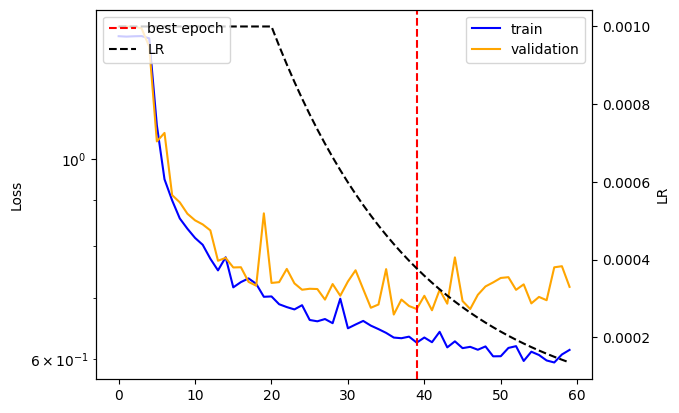

In [ ]:
f,ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(train_curve,label="train",color="blue")
ax.plot(val_curve,label="validation",color="orange")
ax2.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
ax.legend(loc=1)
ax.set_ylabel("Loss")


ax2.plot(lr_curve,"k--",label="LR",)
ax2.legend(loc=2)
plt.xlabel("Epochs")
ax2.set_ylabel("LR")
ax.set_yscale("log")

In [ ]:
model=Net()
model.load_state_dict(torch.load('results/best_weights.pth'))
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv1_1): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv1_2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (dpo1): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            
            outputs = model(inputs)
            targets = targets.numpy()
            outputs = outputs.numpy()

            predicted = np.argmax(outputs, 1)
            targets = np.argmax(targets , 1)

            y_true.extend(targets)
            y_pred.extend(predicted)

    cm = confusion_matrix(y_true, y_pred,normalize="true")

    return np.array(y_true), np.array(y_pred), cm

In [ ]:
_,_,cm=test_model(model, test_loader)

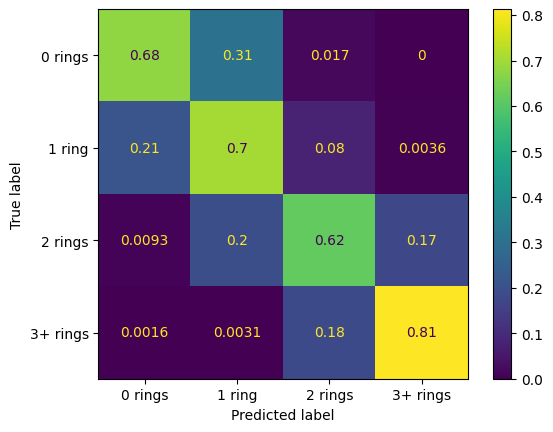

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["0 rings", "1 ring", "2 rings", "3+ rings"])
disp.plot()

plt.show()

In [ ]:
def compute_integrated_gradient(batch_x, batch_blank, c, model,MODE = "max"):
    mean_grad = 0
    n = 64

    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x).squeeze()
        if MODE == "label":
          c = torch.argmax(c)
          y = y[c]
        if MODE == "pred":
          c = torch.argmax(y)
          y = y[c]
        if MODE == "sum": 
          c = torch.argmax(y)  
          y = y.sum()
        if MODE == "confusion": 
          c = torch.argmax(y)
          w = -0.33*torch.ones_like(y)
          w[c]=1

          y = torch.dot(w,y)
        #print(y.shape)
        (grad,) = torch.autograd.grad(y, x,is_grads_batched=False)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients.detach().numpy(),c.detach().numpy().squeeze()

In [ ]:
IGs = []
preds = []

for i, (r,c) in enumerate(test_dataset):
  batch_x = r.unsqueeze(0)
  batch_blank = torch.zeros_like(batch_x)

  IG,pred = compute_integrated_gradient(batch_x, batch_blank, c, model,MODE="max")
  
  IGs.append(IG.squeeze())
  preds.append(pred)

  if i > 127:
    break

In [ ]:
def plot_IG(dat,IG,pred):
  image,lab = dat 
  image,lab = image.numpy().squeeze(),lab.numpy()
  f,ax = plt.subplots(1,2,figsize=(8,5))
  ax[0].matshow(image)
  ax[0].set_title(" class {}".format(np.argmax(lab)),fontsize=30)
  ax[1].matshow(IG,cmap="seismic",vmin=-1,vmax=1)
  ax[1].set_title("IG {}".format(pred),fontsize=30)
  print(np.unique(image))

[0.         0.07142857 0.14285715]
[0.         0.02272727 0.04545455 0.06818182]
[0.   0.04 0.08]
[0.         0.09090909 0.18181819]
[0.  0.1]
[0.  0.1 0.2]
[0.         0.05263158 0.10526316]
[0.         0.05263158 0.10526316]
[0.         0.14285715]
[0.         0.09090909 0.18181819]


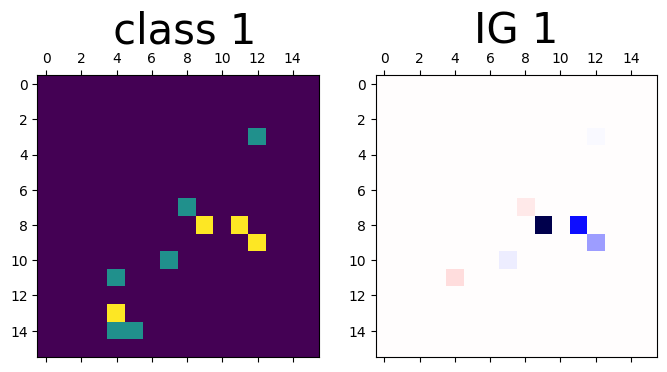

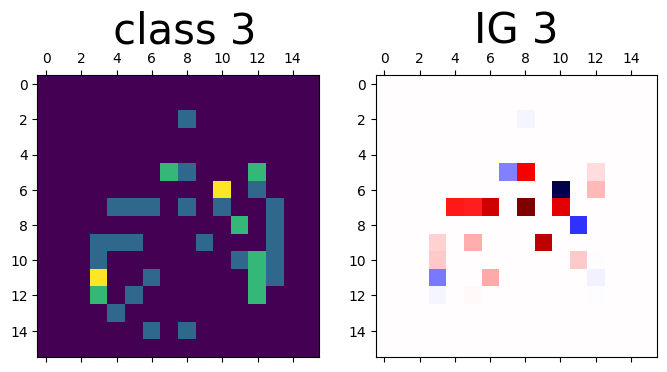

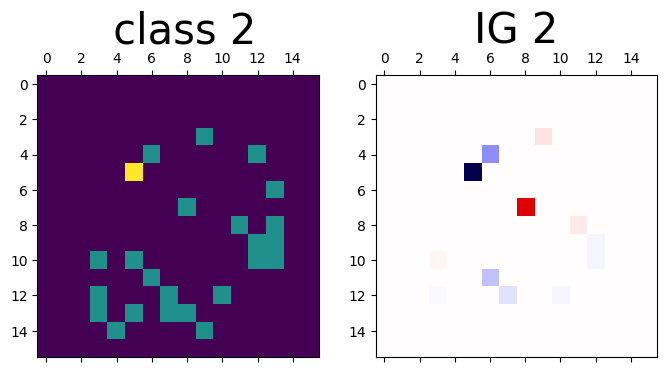

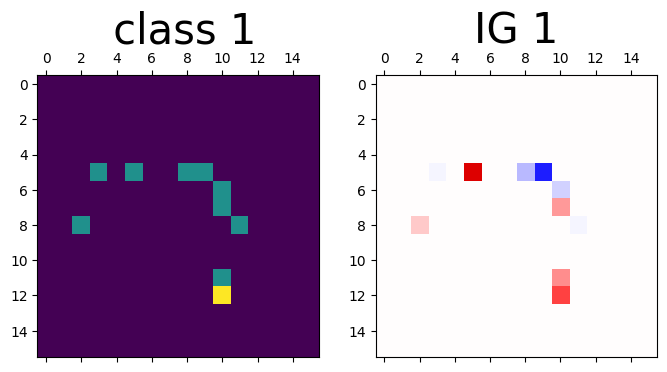

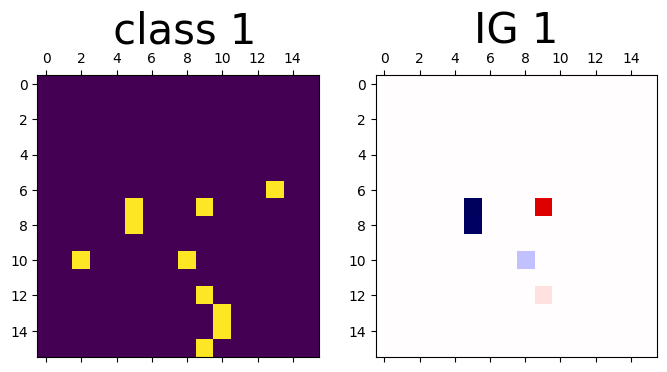

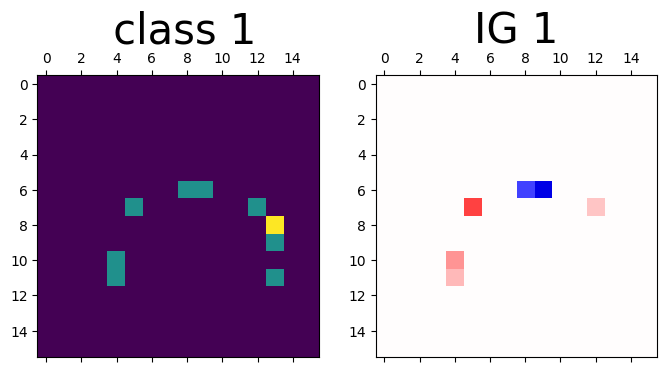

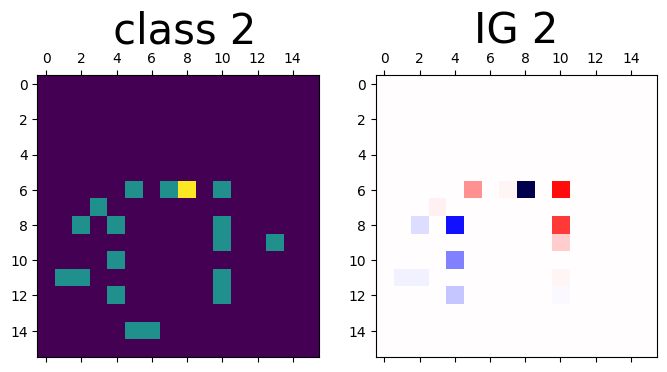

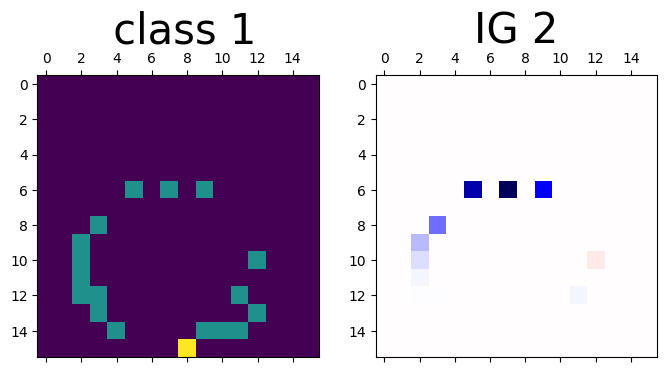

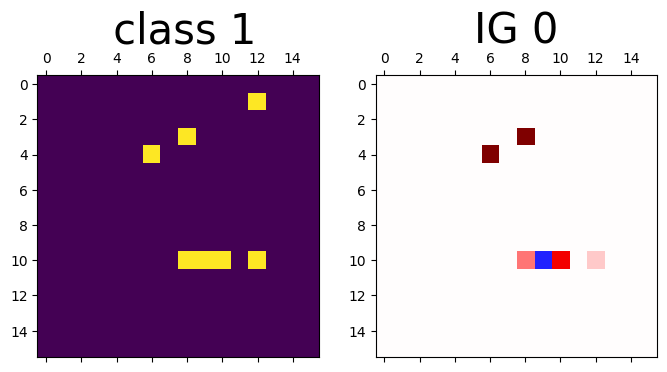

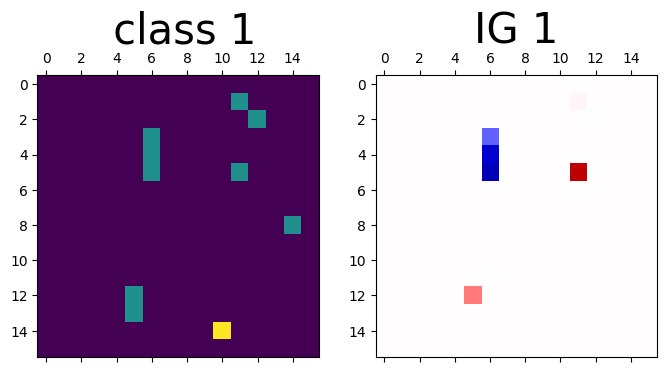

In [ ]:
for i in range(10):
  to_plot = i
  plot_IG(test_dataset[to_plot],IGs[to_plot],preds[to_plot])